# offset free NMPC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control

from openmpc.filters import KF, KFParameters
from openmpc.models import LinearSystem
from openmpc.mpc import SetPointTrackingMPC, MPCProblem

# Define the continuous-time system matrices from the provided example
Ac = np.array([[0, 0, 1.132, 0, -1.0],
               [0, -0.054, -0.171, 0, 0.071],
               [0, 0, 0, 1, 0],
               [0, 0.049, 0, -0.856, -1.01],
               [0, -0.291, 0, 1.053, -0.686]])
Bc = np.array([[0, 0, 0],
               [-36, 20, 0],
               [0, 0, 0],
               [1325, 0, -57],
               [472, 0, -3]])
Cc = np.array([[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, 0, 0]])
Dc = np.zeros((3, 3))

# Discretize the system with a sampling period
Ts = 0.1
linear_system = LinearSystem.c2d(Ac, Bc, Cc, Dc, Ts)

A = linear_system.A
B = linear_system.B
C = linear_system.C
D = linear_system.D

# Disturbance matrices (discrete-time)
Bd = np.zeros((5, 3))  # No direct effect of disturbance on state dynamics
Cd = np.eye(3)         # Identity matrix for output disturbances
linear_system.set_disturbance_interface(Bd,Cd)

# Define the cost matrices
Q = np.diag([100, 100, 1, 0, 0])  # State penalty
R = 1e4 * np.diag([1, 1, 10])     # Input penalty
T = 10  # Prediction horizon

# Create the MPC parameters object
mpc_params = MPCProblem(system  = linear_system, 
                        horizon = T, 
                        Q       = Q, 
                        R       = R)

# Add input constraints (e.g., -1 ≤ u_i(t) ≤ 1)
mpc_params.add_input_magnitude_constraint(limit=1)

# Set up the Kalman filter parameters
kf_params = KFParameters(system  = linear_system, 
                         Sigma_w = np.eye(linear_system.size_state)*0.5,
                         Sigma_v = np.eye(linear_system.size_output)*0.5,
                         P0      = np.eye(linear_system.size_state),
                         x0      = np.zeros(linear_system.size_state))

kf_params.add_constant_disturbance_prediction(Sigma_wd = np.eye(linear_system.size_disturbance)*0.1, 
                                              d0       = np.zeros(linear_system.size_disturbance), 
                                              P0d      = np.eye(linear_system.size_disturbance))

kf = KF(kf_params, is_stationary=True)

# Create the tracking MPC object
mpc_tracking = SetPointTrackingMPC(mpc_params)

# Simulation parameters
T_sim = 150
x0    = np.zeros(5)  # Initial state

# Define the reference array to match the system's output dimensions (3)
reference_array = np.zeros((T_sim, 3))  # Now, it has 3 elements per time step
reference_array[50:, 0] = 200  # Step change in altitude (first output)
reference_array[50:, 1] = 100  # Step change in speed (second output)

x_sim = np.zeros((5, T_sim + 1))
u_sim = np.zeros((T_sim, 3))
x_sim[:, 0] = x0

disturbance = np.zeros((T_sim, 3))  # No disturbance specified

# Simulation loop
for t in range(T_sim):
    current_state = x_sim[:, t].flatten()  # Ensure current_state is 1D
    
    # Create disturbance as a 3-dimensional column vector
    disturbance_current = disturbance[t, :]
    
    # Calculate the output, including noise
    y_t = C @ current_state + Cd @ disturbance_current + np.random.normal(0, 0.1, size=C.shape[0])

    # Kalman filter measurement update
    kf.measurement_update(y_t, u_sim[t - 1] if t > 0 else np.zeros(3))

    # Get the state and disturbance estimates
    x_hat = kf.get_state_estimate()
    d_hat = kf.get_disturbance_estimate()

    # Get the reference for this time step
    reference = reference_array[t, :]  # Now includes 3 elements

    # Control action based on estimates
    u_t = mpc_tracking.get_control_action(x_hat, reference, d_hat)
    
    # Update system dynamics (ensure correct shape)
    x_sim[:, t + 1] = linear_system.discrete_dynamics(current_state, u_t, disturbance_current)
    u_sim[t, :]     = u_t
    # Kalman filter prediction update
    kf.prediction_update(u_t.flatten())



[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.42058013e-03  9.94513045e-01  2.84564942e-04  6.06734637e-03
  -2.77535352e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.13191854e-01 -1.70533320e-02  9.99998433e-01 -4.86606051e-05
   2.41144991e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.99315608e-04 -4.74693596e-04  9.56726585e-02  9.13055646e-01
   9.73194377e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.66594762e-02  6.85876845e-03 -4.79296431e-03 -9.33212074e-02
   9.28669411e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

LinAlgError: The associated symplectic pencil has eigenvalues too close to the unit circle

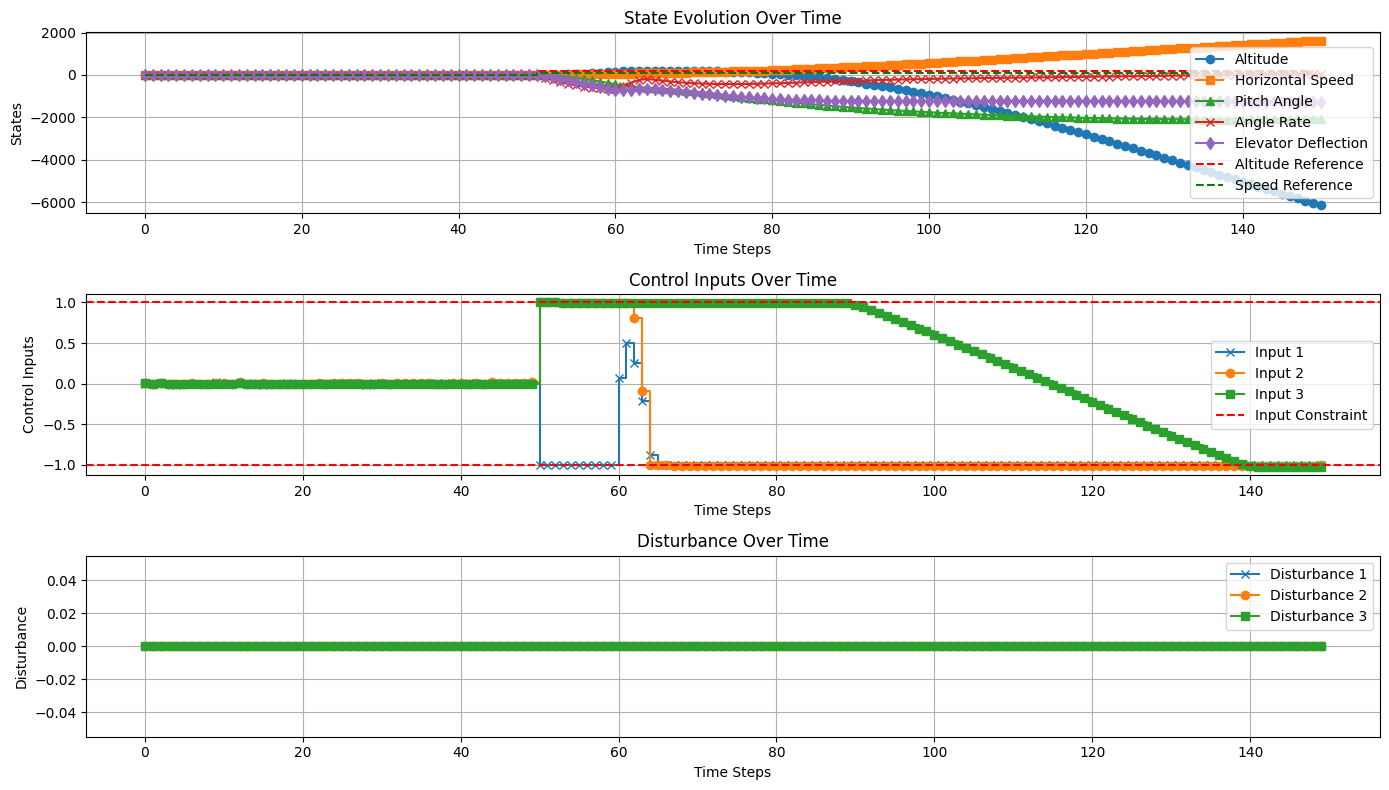

In [ ]:
import matplotlib.pyplot as plt

# Time vectors for plotting
time_steps = np.arange(T_sim + 1)  # For state plots
time_steps_u = np.arange(T_sim)  # For control input plots

# Plotting the simulation results
plt.figure(figsize=(14, 8))

# Plot states
plt.subplot(3, 1, 1)
plt.plot(time_steps, x_sim[0, :], label='Altitude', marker='o')
plt.plot(time_steps, x_sim[1, :], label='Horizontal Speed', marker='s')
plt.plot(time_steps, x_sim[2, :], label='Pitch Angle', marker='^')
plt.plot(time_steps, x_sim[3, :], label='Angle Rate', marker='x')
plt.plot(time_steps, x_sim[4, :], label='Elevator Deflection', marker='d')
plt.step(time_steps_u, reference_array[:, 0], where='post', linestyle='--', color='r', label='Altitude Reference')
plt.step(time_steps_u, reference_array[:, 1], where='post', linestyle='--', color='g', label='Speed Reference')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.title('State Evolution Over Time')
plt.legend(loc='best')
plt.grid(True)

# Plot control inputs
plt.subplot(3, 1, 2)
plt.step(time_steps_u, u_sim[:, 0], where='post', label='Input 1', marker='x')
plt.step(time_steps_u, u_sim[:, 1], where='post', label='Input 2', marker='o')
plt.step(time_steps_u, u_sim[:, 2], where='post', label='Input 3', marker='s')
plt.axhline(1, color='r', linestyle='--', label='Input Constraint')
plt.axhline(-1, color='r', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Control Inputs')
plt.title('Control Inputs Over Time')
plt.legend(loc='best')
plt.grid(True)

# Plot the disturbance for reference
plt.subplot(3, 1, 3)
plt.step(time_steps_u, disturbance[:, 0], where='post', label='Disturbance 1', marker='x')
plt.step(time_steps_u, disturbance[:, 1], where='post', label='Disturbance 2', marker='o')
plt.step(time_steps_u, disturbance[:, 2], where='post', label='Disturbance 3', marker='s')
plt.xlabel('Time Steps')
plt.ylabel('Disturbance')
plt.title('Disturbance Over Time')
plt.legend(loc='best')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
